In [39]:
#from https://www.datacamp.com/community/tutorials/autoencoder-classifier-python#import keras
import os
import time
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from tensorflow.image import central_crop
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Input,Dense,Flatten,Dropout,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adadelta, RMSprop,SGD,Adam
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from keras.utils import to_categorical
import cv2
from numpy import savez_compressed

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.debugging.set_log_device_placement(True)
gpus = tf.config.experimental.list_logical_devices('GPU')


Num GPUs Available:  2


In [42]:
image_size = 288
print(image_size)
## load data of converted images from NPZ
X_train = np.load("X_train-pneunonia-grayscale-(5216, 288, 288, 1).npz")['arr_0']
y_train = np.load("Y_train-pneunonia-grayscale-(5216, 288, 288, 1).npz")['arr_0']
X_val = np.load("X_val-pneunonia-grayscale-(16, 288, 288, 1).npz")['arr_0']
y_val = np.load("Y_val-pneunonia-grayscale-(16, 288, 288, 1).npz")['arr_0']
X_test = np.load("X_test-pneunonia-grayscale-(624, 288, 288, 1).npz")['arr_0']
y_test = np.load("Y_test-pneunonia-grayscale-(624, 288, 288, 1).npz")['arr_0']
# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
from keras.utils.np_utils import to_categorical
y_trainHot = to_categorical(y_train, num_classes = 2)
y_testHot = to_categorical(y_test, num_classes = 2)
y_valHot = to_categorical(y_val, num_classes = 2)


288


In [43]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(5216, 288, 288, 1)
(5216,)
(624, 288, 288, 1)
(624,)


In [44]:
# Deal with imbalanced class sizes below
# Make Data 1D for compatability upsampling methods
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
print(X_trainShape)
print(X_testShape)
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)
Y_train = y_train
Y_test = y_test
print(X_trainFlat.shape)
print(X_testFlat.shape)

82944
82944
(5216, 82944)
(624, 82944)


In [45]:
src_size  = 288
#ros = RandomOverSampler(sampling_strategy='auto')
ros = RandomUnderSampler(sampling_strategy='auto')
X_trainRos, Y_trainRos = ros.fit_sample(X_trainFlat, Y_train)
X_testRos, Y_testRos = ros.fit_sample(X_testFlat, Y_test)
# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_trainRosHot = to_categorical(Y_trainRos, num_classes = 2)
Y_testRosHot = to_categorical(Y_testRos, num_classes = 2)
# Make Data 2D again
for i in range(len(X_trainRos)):
    height, width, channels = src_size,src_size,1
    X_trainRosReshaped = X_trainRos.reshape(len(X_trainRos),height,width,1)
for i in range(len(X_testRos)):
    height, width, channels = src_size,src_size,1
    X_testRosReshaped = X_testRos.reshape(len(X_testRos),height,width,1)


{0: 'No Pneumonia', 1: 'Yes Pneumonia'}


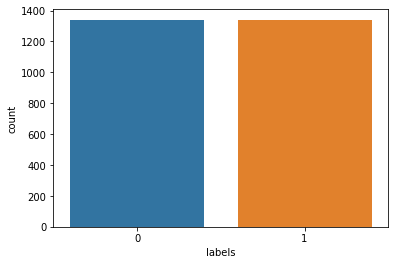

In [46]:
# Plot Label Distribution
dfRos = pd.DataFrame()
dfRos["labels"]=Y_trainRos
labRos = dfRos['labels']
df = pd.DataFrame()
df["labels"]=y_train
lab = df['labels']
dist = lab.value_counts()
distRos = lab.value_counts()
# Plot Label Distribution
import seaborn
seaborn.countplot(labRos)
print({0: 'No Pneumonia', 1: 'Yes Pneumonia'})

In [47]:
print(X_testRosReshaped.shape)

(468, 288, 288, 1)


In [48]:
#train_data = extract_data('train-images-idx3-ubyte.gz', 60000)
#test_data = extract_data('t10k-images-idx3-ubyte.gz', 10000)
train_data = X_trainRosReshaped
test_data = X_testRosReshaped
print(train_data.shape)
print(test_data.shape)



(2682, 288, 288, 1)
(468, 288, 288, 1)


In [49]:
train_labels = X_testRosReshaped
test_labels = Y_testRosHot
print(train_labels.shape)
print(test_labels.shape)


(468, 288, 288, 1)
(468, 2)


In [50]:
# Shapes of training set
print("Training set (images) shape: {shape}".format(shape=train_data.shape))

# Shapes of test set
print("Test set (images) shape: {shape}".format(shape=test_data.shape))
image_size = 288

Training set (images) shape: (2682, 288, 288, 1)
Test set (images) shape: (468, 288, 288, 1)


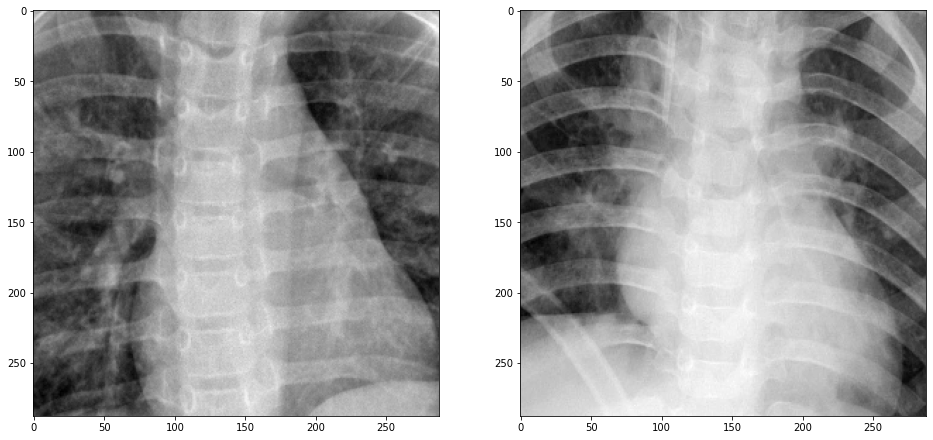

In [51]:
# Create dictionary of target classes
label_dict = {
 0: 'No',
 1: 'Yes'
}
plt.figure(figsize=[16,16])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(train_data[10], (image_size,image_size))
#curr_lbl = train_labels[10:,]
plt.imshow(curr_img, cmap='gray')
#plt.title("(Label: " + str(curr_lbl) + ")")

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(test_data[-20], (image_size,image_size))
curr_lbl = test_labels[-20:,]
plt.imshow(curr_img, cmap='gray')
#plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

In [52]:
train_data = train_data.reshape(-1, image_size,image_size, 1)
test_data = test_data.reshape(-1, image_size,image_size, 1)
train_data.shape, test_data.shape

((2682, 288, 288, 1), (468, 288, 288, 1))

In [53]:
train_data.dtype, test_data.dtype

(dtype('int32'), dtype('int32'))

In [54]:
np.max(train_data), np.max(test_data)

(255, 255)

In [55]:
train_data = train_data / np.max(train_data)
test_data = test_data / np.max(test_data)

In [56]:
np.max(train_data), np.max(test_data)

(1.0, 1.0)

In [57]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(train_data,
                                                             train_data,
                                                             test_size=0.2,
                                                             random_state=13)
print(train_X.shape)
print(valid_X.shape)
print(train_ground.shape)
print(valid_ground.shape)
print(test_data.shape)
print(test_labels.shape)

(2145, 288, 288, 1)
(537, 288, 288, 1)
(2145, 288, 288, 1)
(537, 288, 288, 1)
(468, 288, 288, 1)
(468, 2)


In [58]:
from tensorflow.image import resize as reZ

In [59]:
x, y = 288, 288
inChannel = 1
print(train_X.shape)
print(valid_X.shape)
print(train_ground.shape)
print("Valid: ")
print(valid_ground.shape)
print("Test: ")
print(test_X.shape)
print(test_labels.shape)


batch_size = 4
epochs = 64


input_img = Input(shape = (x, y, inChannel),dtype='float32')
print(input_img)

num_classes = 2

(2145, 288, 288, 1)
(537, 288, 288, 1)
(2145, 288, 288, 1)
Valid: 
(537, 288, 288, 1)
Test: 
(468, 128, 128, 1)
(468, 2)
Tensor("input_2:0", shape=(None, 288, 288, 1), dtype=float32)


In [60]:
print(num_classes)


2


In [61]:
def encoder(input_img):
    #encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #image_size x image_size x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

def decoder(conv4):    
    #decoder
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4) #7 x 7 x 128
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5) #7 x 7 x 64
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    up1 = UpSampling2D((2,2))(conv6) #14 x 14 x 64
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 32
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    up2 = UpSampling2D((2,2))(conv7) # 28 x 28 x 32
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

In [ ]:
with tf.device('/device:GPU:1'):
    autoencoder = Model(input_img, decoder(encoder(input_img)))
    autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop(lr=0.0005))
    autoencoder.summary()
    autoencoder_train = autoencoder.fit(train_X,train_ground, batch_size=batch_size,epochs=epochs,verbose=2,validation_data=(valid_X,valid_ground))
    autoencoder.save_weights("autoencoder-288.h5")

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 288, 288, 1)]     0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 288, 288, 32)      320       
_________________________________________________________________
batch_normalization_22 (Batc (None, 288, 288, 32)      128       
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 288, 288, 32)      9248      
_________________________________________________________________
batch_normalization_23 (Batc (None, 288, 288, 32)      128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 144, 144, 32)      0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 144, 144, 64)      1849

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
537/537 - 233s - loss: 0.0017 - val_loss: 0.0058
Epoch 7/64
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /j

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
537/537 - 233s - loss: 0.0013 - val_loss: 6.1133e-04
Epoch 15/64
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
537/537 - 232s - loss: 0.0012 - 

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
537/537 - 234s - loss: 9.0986e-04 - val_loss: 0.0038
Epoch 24/64
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in de

Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
537/537 - 233s - loss: 7.0436e-04 - val_loss: 0.0021
Epoch 32/64
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in de

Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
537/537 - 234s - loss: 5.7981e-04 - val_loss: 5.2942e-04
Epoch 40/64
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
537/537 - 234s - loss: 5.3772e-04 - val_loss: 0.0019
Epoch 48/64
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in devi

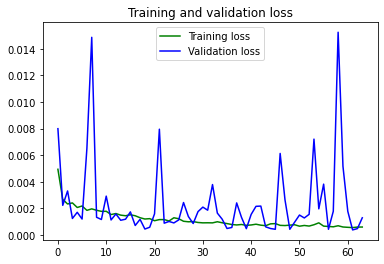

In [24]:

loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs_R = range(epochs)
plt.figure()
plt.plot(epochs_R, loss, 'g', label='Training loss')
plt.plot(epochs_R, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


In [25]:
# Display the change for category label using one-hot encoding
print('Original label:', y_train[0])
print('After conversion to one-hot:', y_trainHot[0])

Original label: 1
After conversion to one-hot: [0. 1.]


In [26]:
def encoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4


In [28]:
def fc(enco):
    flat = Flatten()(enco)
    den = Dense(128, activation='relu')(flat)
    out = Dense(2, activation='sigmoid')(den)
    return out

In [29]:
with tf.device('/device:GPU:1'):
    encode = encoder(input_img)
    full_model = Model(input_img,fc(encode))

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1


In [30]:
autoencoder.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496 

In [31]:
full_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 128, 128, 32)      320       
_________________________________________________________________
batch_normalization_14 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization_15 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 64, 64, 64)        1849

In [32]:
i=0
with tf.device('/device:GPU:1'):
    for l1,l2 in zip(full_model.layers[:19],autoencoder.layers[0:19]):
        print(i)
        i+=1
        l1.set_weights(l2.get_weights())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


In [33]:
autoencoder.get_weights()[0][1]

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0


array([[[-0.08524434, -0.10876896,  0.5410719 , -0.11900674,
          0.01350845,  0.10202122,  0.02194489,  0.32255673,
          0.01379178, -0.02224265, -0.00936822, -0.09382318,
         -0.04011927,  0.11491022,  0.10902512,  0.0169779 ,
         -0.04416739,  0.06235484, -0.17010535, -0.06753449,
          0.03097211,  0.05329888, -0.03802256, -0.05947335,
         -0.0157653 , -0.05696633, -0.15779714,  0.08044539,
         -0.08007812,  0.03708084,  0.05327585, -0.01115423]],

       [[-0.01251921, -0.09317119,  0.11868357, -0.00383316,
         -0.14748102, -0.00278786, -0.12881933,  0.05831682,
          0.04334657,  0.00846816, -0.09334227, -0.15819351,
          0.0229226 , -0.05259383,  0.05116163, -0.06632626,
          0.1286418 ,  0.0913934 ,  0.08916067, -0.05918584,
          0.01620847,  0.03217264,  0.05904395,  0.15042262,
         -0.13291708, -0.09112443,  0.06964035,  0.01939954,
         -0.05948   , -0.02420017, -0.04131332,  0.04025528]],

       [[ 0.125339

In [34]:
with tf.device('/device:GPU:1'):
    full_model.get_weights()[0][1]

In [35]:
with tf.device('/device:GPU:1'):
    for layer in full_model.layers[0:19]:
        layer.trainable = False

In [36]:

with tf.device('/device:GPU:1'):
    full_model.compile(loss="categorical_crossentropy", optimizer = Adam(),metrics=['acc','binary_accuracy','categorical_accuracy'])

In [37]:
full_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 128, 128, 32)      320       
_________________________________________________________________
batch_normalization_14 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization_15 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 64, 64, 64)        1849

In [ ]:
train_X,valid_X,train_label,valid_label = train_test_split(train_data,Y_trainRosHot,test_size=0.2,random_state=13)

In [38]:


filepath="weights-improvement-{epoch:02d}-{loss:.4f}-Autoencoder+2.hdf5"
weights_improvement = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [EarlyStopping(monitor='val_acc', patience=10, verbose=1),weights_improvement]

with tf.device('/device:GPU:1'):
    classify_train = full_model.fit(train_X, train_label, batch_size=4,epochs=64,verbose=2,validation_data=(valid_X, valid_label),callbacks = callbacks_list)
    full_model.save_weights("autoencoder_classification128-1.h5")

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Epoch 1/64
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1

Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
671/671 - 36s - loss: 8.0590 - acc: 0.5000 - binary_accuracy: 0.5000 - categorical_accuracy: 0.5000 - val_loss: 0.8247 - val_acc: 0.4423 - val_binary_accuracy: 0.4658 - val_categorical_accuracy: 0.4423
Epoch 7/64
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:local

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
671/671 - 36s - loss: 8.0590 - acc: 0.5000 - binary_accuracy: 0.5000 - categorical_accuracy: 0.5000 - val_loss: 0.8247 - val_acc: 0.4423 - val_binary_accuracy: 0.4658 - val_categorical_accuracy: 0.4423
Epoch 15/64
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:loca

Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
671/671 - 36s - loss: 8.0651 - acc: 0.5000 - binary_accuracy: 0.5000 - categorical_accuracy: 0.5000 - val_loss: 0.8247 - val_acc: 0.4423 - val_binary_accuracy: 0.4658 - val_categorical_accuracy: 0.4423
Epoch 23/64
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:loca

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
671/671 - 36s - loss: 8.0530 - acc: 0.5000 - binary_accuracy: 0.5000 - categorical_accuracy: 0.5000 - val_loss: 0.8247 - val_acc: 0.4423 - val_binary_accuracy: 0.4658 - val_categorical_accuracy: 0.4423
Epoch 31/64
Executing op RangeDataset in device /job:loca

Epoch 38/64
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
671/671 - 36s - loss: 8.0651 - acc: 0.5000 - binary_accuracy: 0.5000 - categorical_accuracy: 0.5000 - val_loss: 0.8247 - val_acc: 0.4423 - val_binary_accuracy: 0.4658

Epoch 46/64
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
671/671 - 36s - loss: 8.0651 - acc: 0.5000 - binary_accuracy: 0.5000 - categorical_accuracy: 0.5000 - val_loss: 0.8247 - val_acc: 0.4423 - val_binary_accuracy: 0.4658

Epoch 54/64
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
671/671 - 36s - loss: 8.0530 - acc: 0.5000 - binary_accuracy: 0.5000 - categorical_accuracy: 0.5000 - val_loss: 0.8247 - val_acc: 0.4423 - val_binary_accuracy: 0.4658

KeyboardInterrupt: 

In [65]:
import sklearn
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')
    
x_val = reZ(X_val,(128,128))
print(x_val.shape)
print(y_valHot.shape)

with tf.device('/device:GPU:1'):
    score = full_model.evaluate(x_val,y_valHot, verbose=2)
    y_pred = full_model.predict(x_val)

print('\nKeras CNN - accuracy:', score[1], '\n')
labels = {0: 'No Pneumonia', 1: 'Yes Pneumonia'}
pprint(score)

print('\n', sklearn.metrics.classification_report(np.where(y_valHot > 0)[1], np.argmax(y_pred, axis=1), target_names=list(labels.values())), sep='') 
Y_pred_classes = np.argmax(y_pred,axis = 1) 
Y_true = np.argmax(y_valHot,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
#plotKerasLearningCurve()
plt.show()
plot_learning_curve(classify_train)
plt.show()
plot_confusion_matrix(confusion_mtx, classes = list(labels.values()))
plt.show()

(16, 128, 128, 1)
(16, 2)


InternalError: GPU sync failed

https://towardsdatascience.com/deciding-optimal-filter-size-for-cnns-d6f7b56f9363